### Quick Example With Limited Income 



In [26]:
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt 
import numpy as np
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display_html

%matplotlib inline 

In [27]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [28]:
def clean_objs(dff):
    dff = dff.copy()
    dff.loc[:,dff.dtypes == 'object'] = dff.loc[:,dff.dtypes == 'object'].applymap(lambda x: x.strip())
    return dff

In [29]:
df = pd.read_csv('./data/large_train_sample.csv')

X_test = pd.read_csv('./data/test_data.csv')

df_cheap_sample = pd.read_csv('./data/cheap_test_sample.csv')

In [30]:
y_test = pd.read_csv('./data/y_test.csv')

y_test['wage'] = y_test['wage'].map({1:'>50K', 0:'<=50K'})

In [31]:
df = clean_objs(df)
X_test = clean_objs(X_test)
df_cheap_sample = clean_objs(df_cheap_sample)

In [32]:
def percent_upper_income(col):
    return sum(1 for x in col if x == '>50K')/ len(col)

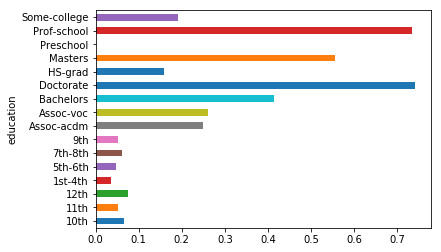

In [33]:
df.groupby('education')['wage'].agg(percent_upper_income).plot(kind='barh');

In [34]:
df['education'].unique()

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

In [9]:
highest = ['Prof-school', 'Doctorate']
assoc = ['Assoc-voc', 'Assoc-acdm']
hs = ['Some-college', 'HS-grad']

education_mapper = {}

for level in df['education'].unique():
    if level in highest:
        education_mapper[level] = 5
    elif level == 'Masters':
        education_mapper[level] = 4
    elif level == 'Bachelors':
        education_mapper[level] = 3
    elif level in assoc:
        education_mapper[level] = 2
    elif level in hs:
        education_mapper[level] = 1
    else:
        education_mapper[level] = 0 
education_mapper      

{'10th': 0,
 '11th': 0,
 '12th': 0,
 '1st-4th': 0,
 '5th-6th': 0,
 '7th-8th': 0,
 '9th': 0,
 'Assoc-acdm': 2,
 'Assoc-voc': 2,
 'Bachelors': 3,
 'Doctorate': 5,
 'HS-grad': 1,
 'Masters': 4,
 'Preschool': 0,
 'Prof-school': 5,
 'Some-college': 1}

In [10]:
def cleaner(df_in, is_test=False, train_df=None):
    df_in = df_in.copy()
    df_in['education'] =  df_in['education'].map(education_mapper)
    df_in = pd.get_dummies(df_in)
    if is_test:
        not_in_test = list(set(train_df.columns) - set(df_in.columns))
        not_in_train = list(set(df_in.columns) - set(train_df.columns))
        if len(not_in_test) > 0:
            new_col_df = pd.DataFrame(np.zeros((df_in.shape[0], len(not_in_test))), columns=not_in_test)
            df_in = pd.concat([df_in, new_col_df], axis=1)
        if len(not_in_train) > 0:
            df_in = df_in.drop(columns=not_in_train)
        
    return df_in 

In [11]:
X_train = cleaner(df.drop(columns=['wage']))
y_train = df['wage']
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train);

In [12]:
X_test_model = cleaner(X_test, is_test=True, train_df=X_train)

X_cheap_sample = cleaner(df_cheap_sample.drop(columns=['wage']))

In [13]:
rf_cheap = RandomForestClassifier(n_estimators=100)

In [14]:
y_train_cheap = df_cheap_sample['wage']
X_test_model_cheap_sample = cleaner(X_test, is_test=True, train_df=X_cheap_sample)

In [15]:
rf_cheap.fit(X_cheap_sample, y_train_cheap);

In [16]:
predict_probas_cheap = rf_cheap.predict_proba(X_test_model_cheap_sample)[:,1]

In [17]:
predict_probas = rf.predict_proba(X_test_model)[:,1]

In [18]:
rf.classes_

array(['<=50K', '>50K'], dtype=object)

In [22]:
def plot_model(threshold, probas1, descrip1, probas2=[], descrip2 = False, y_test = y_test):
    """
    Functions takes a threshold value, predicted probabilities of income >50K and a description of the model. 
    
    Additional model probabilities can be displayed side by side if entered. 
    """
    ### helper function 
    def get_predictions(probabilities, threshold):
        return ['<=50K' if prob < threshold else '>50K' for prob in probabilities] 
    
    ### helper function 
    def get_plotting_info(probas, thresh):
        predictions = get_predictions(probas, thresh)

        fprs, tprs, _ = roc_curve(y_test, probas, pos_label='>50K')
        fpr_model = confusion_matrix(y_test, predictions)[0][1]/ sum(confusion_matrix(y_test, predictions)[0])
        tpr_model = confusion_matrix(y_test, predictions)[1][1]/ sum(confusion_matrix(y_test, predictions)[1])

        acc_score = accuracy_score(y_test, predictions)

        return fprs, tprs, fpr_model, tpr_model, acc_score, predictions
    
    ### main function 
    fprs, tprs, fpr_model, tpr_model, accuracy, predictions = get_plotting_info(probas1, threshold)
    dct = {}
    dct[descrip1] = [round(accuracy,4), round(roc_auc_score(y_test, probas1), 4)]
    
    if len(probas2) > 0:
        fprs2, tprs2, fpr_model2, tpr_model2, accuracy2, predictions2 = get_plotting_info(probas2, threshold)
        dct[descrip2] = [round(accuracy2,4), round(roc_auc_score(y_test, probas2), 4)]
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(fprs, tprs, label=descrip1, color='blue')
    if len(probas2) > 0:
        ax.plot(fprs2, tprs2, label=descrip2, color='orange')
    ax.plot([0,1], [0,1], linestyle='--', color='black')
    ax.plot(fpr_model, tpr_model, marker = 'o', linewidth=20, color = 'blue')
    if len(probas2) > 0:
        ax.plot(fpr_model2, tpr_model2, marker = 'o', linewidth=20, color = 'orange')
    ax.set_ylabel('True Positive Rate', fontsize=18)
    ax.set_xlabel('False Positive Rate', fontsize=18)
    ax.legend()
    display(pd.DataFrame(dct, index=['Accuracy Score', 'AUC_ROC']))
    cm1 = pd.DataFrame(confusion_matrix(y_test, predictions),columns=pd.MultiIndex.from_product([[descrip1], ['Predicted <=50K', 'Predicted >50K']]),\
             index=['True <=50K', 'True >50K']) 
    if len(probas2) > 0:
        cm2 = pd.DataFrame(confusion_matrix(y_test, predictions2),columns=pd.MultiIndex.from_product([[descrip2], ['Predicted <=50K', 'Predicted >50K']]),\
             index=['True <=50K', 'True >50K']) 
        display_side_by_side(cm1, cm2)
    else:
        display(cm1)
        

In [36]:
interact(plot_model,y_test=fixed(y_test), threshold =(-.01,1.01, .01), probas1=fixed(predict_probas), descrip1=fixed('No Limitations'),\
        probas2= fixed(predict_probas_cheap), descrip2=fixed('Limited Data'));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.01, min=-0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

,No Limitations,Limited Data
Accuracy Score,0.9297,0.9065
AUC_ROC,0.9725,0.9611


No Limitations 
 
 
 
 Predicted <=50K 
 Predicted >50K 
 
 
 
 
 True <=50K 
 12648 
 464 
 
 
 True >50K 
 681 
 2488 
 
 
 
 
 
 
 Limited Data 
 
 
 
 Predicted <=50K 
 Predicted >50K 
 
 
 
 
 True <=50K 
 12291 
 821 
 
 
 True >50K 
 702 
 2467

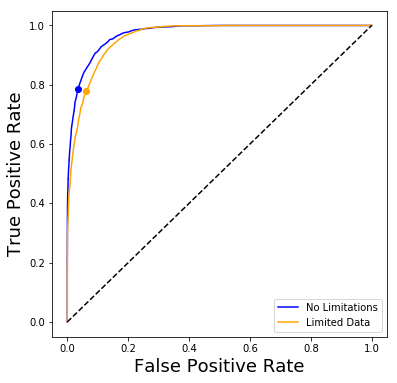

In [35]:
plot_model(.5, predict_probas, 'No Limitations', predict_probas_cheap, 'Limited Data')